In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

from masterthesis_helper_functions import split_data_forecasting_window_with_validation
from masterthesis_helper_functions import plot_date_range
from masterthesis_helper_functions import evaluate_regression
from masterthesis_helper_functions import plot_actual_vs_predicted_time_series
from masterthesis_helper_functions import plot_actual_vs_predicted
from masterthesis_helper_functions import plot_residuals_vs_predicted
from masterthesis_helper_functions import split_data_random_intervals

In [2]:
if 'Combined_Load_And_TrafoData' not in locals():
    print('Data not in memory')
    print('Loading Combined_Load_And_TrafoData.csv...')
    Combined_Load_And_TrafoData = pd.read_csv('240226_Combined_Load_And_TrafoData.csv', index_col=0, parse_dates=True)
elif 'Combined_Load_And_TrafoData' in locals():
    print('Data already in memory')
    pass

print('Data is now availlable in the variable Combined_Load_And_TrafoData')

Data not in memory
Loading Combined_Load_And_TrafoData.csv...
Data is now availlable in the variable Combined_Load_And_TrafoData


C:\Users\matbi\AppData\Local\Temp\ipykernel_21772\2874138183.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Combined_Load_And_TrafoData = pd.read_csv('240226_Combined_Load_And_TrafoData.csv', index_col=0, parse_dates=True)


In [3]:
Combined_Load_And_TrafoData.head()

,datetime,trafo_p_hv_mw,trafo_q_hv_mvar,trafo_p_lv_mw,trafo_q_lv_mvar,trafo_pl_mw,trafo_ql_mvar,trafo_i_hv_ka,trafo_i_lv_ka,trafo_vm_hv_pu,...,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13
0,2016-01-01 00:00:00,-0.138606,0.036278,0.140890,-0.031716,0.002285,0.004562,0.004035,0.202417,1.025,...,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0
1,2016-01-01 00:15:00,-0.130922,0.035803,0.133022,-0.031707,0.002100,0.004096,0.003823,0.191789,1.025,...,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0
2,2016-01-01 00:30:00,-0.126639,0.035554,0.128641,-0.031707,0.002002,0.003847,0.003704,0.185882,1.025,...,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0
3,2016-01-01 00:45:00,-0.126705,0.035556,0.128708,-0.031706,0.002003,0.003851,0.003706,0.185972,1.025,...,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0
4,2016-01-01 01:00:00,-0.126007,0.035517,0.127994,-0.031706,0.001988,0.003811,0.003687,0.185010,1.025,...,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0


In [4]:
df = Combined_Load_And_TrafoData.copy()

# Convert 'datetime' column to datetime type if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

# Calculate the moving averages
df['SMA_15m'] = df['trafo_p_lv_mw'].rolling(window=1, min_periods=1).mean()  # Change window size if data is not hourly
df['SMA_1h'] = df['trafo_p_lv_mw'].rolling(window=4, min_periods=1).mean()   # Same as above, adjust if necessary
df['SMA_6h'] = df['trafo_p_lv_mw'].rolling(window=24, min_periods=1).mean()
df['SMA_1d'] = df['trafo_p_lv_mw'].rolling(window=96, min_periods=1).mean()

# Print the last few rows to check
print(df[['trafo_p_lv_mw', 'SMA_15m', 'SMA_1h', 'SMA_6h', 'SMA_1d']].tail())


                     trafo_p_lv_mw   SMA_15m    SMA_1h    SMA_6h    SMA_1d
datetime                                                                  
2016-12-31 22:45:00       0.134772  0.134772  0.134194  0.131231  0.136689
2016-12-31 23:00:00       0.136555  0.136555  0.135784  0.131161  0.136663
2016-12-31 23:15:00       0.143326  0.143326  0.137614  0.131523  0.136695
2016-12-31 23:30:00       0.140786  0.140786  0.138860  0.131910  0.136711
2016-12-31 23:45:00       0.140488  0.140488  0.140289  0.132248  0.136704


In [6]:
# Now, generate intervals with random lengths between 4 and 14 days
# Determine the range of the dataset
start_date = df.index.min()
end_date = df.index.max()
random_intervals = split_data_random_intervals(df, start_date, end_date, 4, 14, seed = 4711)

In [7]:
random_intervals

[                     trafo_p_hv_mw  trafo_q_hv_mvar  trafo_p_lv_mw  \
 datetime                                                             
 2016-01-01 00:00:00      -0.138606         0.036278       0.140890   
 2016-01-01 00:15:00      -0.130922         0.035803       0.133022   
 2016-01-01 00:30:00      -0.126639         0.035554       0.128641   
 2016-01-01 00:45:00      -0.126705         0.035556       0.128708   
 2016-01-01 01:00:00      -0.126007         0.035517       0.127994   
 ...                            ...              ...            ...   
 2016-01-06 23:00:00      -0.142407         0.036520       0.144787   
 2016-01-06 23:15:00      -0.142201         0.036507       0.144576   
 2016-01-06 23:30:00      -0.143169         0.036569       0.145569   
 2016-01-06 23:45:00      -0.143992         0.036624       0.146412   
 2016-01-07 00:00:00      -0.144237         0.036640       0.146663   
 
                      trafo_q_lv_mvar  trafo_pl_mw  trafo_ql_mvar  \
 datet

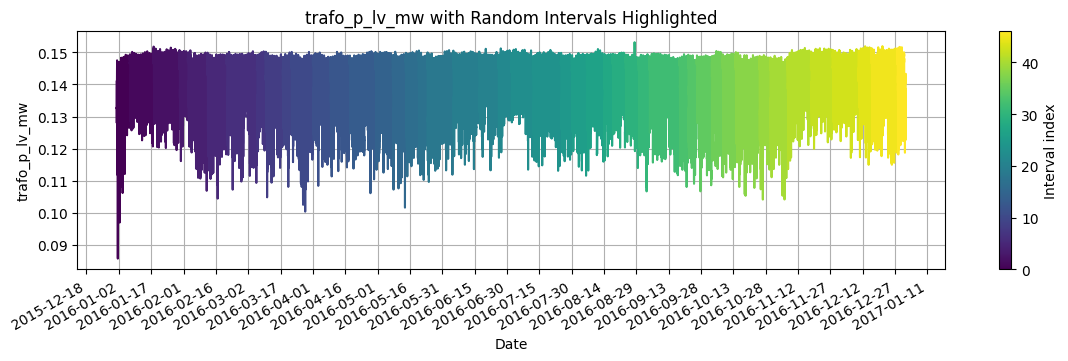

In [12]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(14, 3.5))

# Create a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(random_intervals)))

# Plot each interval in a different color
for interval, color in zip(random_intervals, colors):
    ax.plot(interval.index, interval['trafo_p_lv_mw'], color=color)

# Set the title and labels
ax.set_title('trafo_p_lv_mw with Random Intervals Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('trafo_p_lv_mw')

# Set the format of the dates on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
fig.autofmt_xdate()  # Rotate date labels to prevent overlap
ax.grid(True)

# Create a ScalarMappable and use it for the colorbar
norm = plt.Normalize(vmin=0, vmax=len(random_intervals))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # This line is necessary for ScalarMappable
plt.colorbar(sm, ax=ax, label='Interval index')  # Link the colorbar to the created axes

plt.show()

In [8]:
# Assume random_intervals is a list of DataFrames, each representing a random interval
forecasts = []  # Store forecasts here
actuals = []    # Store actual values here
results = []    # Store evaluation results here

# We'll use a simple moving average with a window size of your choice; let's say 24 hours for this example
window_size = 24  # Adjust based on your data's granularity and needs

for i in range(len(random_intervals) - 1):  # We forecast for the next interval, hence -1
    current_interval = random_intervals[i]
    next_interval = random_intervals[i + 1]
    
    # Calculate SMA for the current interval
    sma = current_interval['trafo_p_lv_mw'].rolling(window=window_size, min_periods=1).mean()
    
    # Forecast is the last value of SMA
    forecast = sma.iloc[-1]
    actual = next_interval['trafo_p_lv_mw'].iloc[0]  # We're assuming you want to forecast the first value of the next interval
    
    # Store the forecasts and actuals
    forecasts.append(forecast)
    actuals.append(actual)
    
    # Now, we'll prepare a dummy 'X' since your SMA doesn't use features like traditional regressions
    # This is just for compatibility with your evaluation function
    X_dummy = np.zeros((next_interval.shape[0], 1))  # One predictor, equal to number of samples
    
    # Evaluate the forecast
    metrics = evaluate_regression(np.array([actual]), np.array([forecast]), X_dummy)
    results.append(metrics)

# At this point, 'results' contains the evaluation metrics for each interval's forecast
# You can print them out or aggregate them as needed
for i, metrics in enumerate(results):
    print(f"Interval {i + 1}:")
    for key, value in metrics.items():
        print(f"  {key}: {value}")
    print()  # Newline for better readability


Interval 1:
  MAE: 0.010417846363947242
  MSE: 0.00010853152286280876
  MEDAE: 0.010417846363947242
  RMSE: 0.010417846363947242
  R^2: nan
  Adjusted R^2: nan
  MAPE: 1.0417846363947243

Interval 2:
  MAE: 0.009681911545980082
  MSE: 9.373941118418242e-05
  MEDAE: 0.009681911545980082
  RMSE: 0.009681911545980082
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.9681911545980082

Interval 3:
  MAE: 0.009975813581042853
  MSE: 9.951685660371903e-05
  MEDAE: 0.009975813581042853
  RMSE: 0.009975813581042853
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.9975813581042853

Interval 4:
  MAE: 0.009806737589617864
  MSE: 9.6172102151624e-05
  MEDAE: 0.009806737589617864
  RMSE: 0.009806737589617864
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.9806737589617864

Interval 5:
  MAE: 0.012550316980400433
  MSE: 0.00015751045630852745
  MEDAE: 0.012550316980400433
  RMSE: 0.012550316980400433
  R^2: nan
  Adjusted R^2: nan
  MAPE: 1.2550316980400433

Interval 6:
  MAE: 0.014641093351678236
  MSE: 0.0002143616145325

c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2

In [27]:
# Define the window sizes for different forecast horizons
window_sizes = {
    '15min': 1,
    '1h': 4,
    '6h': 24,
    '1day': 96,
}

# Initialize a dictionary to hold results for each forecast horizon
results = {horizon: [] for horizon in window_sizes.keys()}

for horizon, window_size in window_sizes.items():
    for i in range(len(random_intervals) - 1):  # We forecast for the next interval, hence -1
        current_interval = random_intervals[i]
        next_interval = random_intervals[i + 1]

        # Calculate SMA for the current interval based on the window size
        sma = current_interval['trafo_p_lv_mw'].rolling(window=window_size, min_periods=1).mean()

        # Forecast is the last value of SMA
        forecast = sma.iloc[-1]
        actual = next_interval['trafo_p_lv_mw'].iloc[0]  # We're assuming you want to forecast the first value of the next interval

        # Prepare a dummy 'X' for compatibility with the evaluation function
        X_dummy = np.zeros((1, 1))  # One predictor, one sample

        # Evaluate the forecast
        metrics = evaluate_regression(np.array([actual]), np.array([forecast]), X_dummy)
        results[horizon].append(metrics)

# Compute mean values for each metric across all intervals for each forecast horizon
mean_results = {}
for horizon in window_sizes.keys():
    mean_results[horizon] = {metric: np.mean([result[metric] for result in results[horizon]]) for metric in results[horizon][0]}

# Display the mean of each metric for each forecast horizon
for horizon, metrics in mean_results.items():
    print(f"Mean metrics for {horizon} forecast:")
    for metric, mean_value in metrics.items():
        print(f"  {metric}: {mean_value}")
    print()  # Newline for readability


Mean metrics for 15min forecast:
  MAE: 0.0
  MSE: 0.0
  MEDAE: 0.0
  RMSE: 0.0
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.0

Mean metrics for 1h forecast:
  MAE: 0.001088972551087017
  MSE: 1.967920419340532e-06
  MEDAE: 0.001088972551087017
  RMSE: 0.001088972551087017
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.10889725510870171

Mean metrics for 6h forecast:
  MAE: 0.011370875301110266
  MSE: 0.00013558280644929724
  MEDAE: 0.011370875301110266
  RMSE: 0.011370875301110266
  R^2: nan
  Adjusted R^2: nan
  MAPE: 1.1370875301110266

Mean metrics for 1day forecast:
  MAE: 0.007837970464820097
  MSE: 6.897181723133543e-05
  MEDAE: 0.007837970464820097
  RMSE: 0.007837970464820097
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.7837970464820098



c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2

In [41]:
# Initialize dictionaries to store the cumulative metrics for averages
average_metrics = {
    '15min': {'MAE': [], 'MSE': [], 'MEDAE': [], 'RMSE': [], 'R^2': [], 'Adjusted R^2': [], 'MAPE': []},
    '1h': {'MAE': [], 'MSE': [], 'MEDAE': [], 'RMSE': [], 'R^2': [], 'Adjusted R^2': [], 'MAPE': []},
    '6h': {'MAE': [], 'MSE': [], 'MEDAE': [], 'RMSE': [], 'R^2': [], 'Adjusted R^2': [], 'MAPE': []},
    '1d': {'MAE': [], 'MSE': [], 'MEDAE': [], 'RMSE': [], 'R^2': [], 'Adjusted R^2': [], 'MAPE': []}
}

# Define window sizes for different time frames
windows = {'15min': 1, '1h': 4, '6h': 24, '1d': 96}

# Iterate through each window size
for time_frame, window_size in windows.items():
    for i in range(len(random_intervals) - 1):  # We forecast for the next interval, hence -1
        current_interval = random_intervals[i]
        next_interval = random_intervals[i + 1]

        # Calculate SMA for the current interval
        sma = current_interval['trafo_p_lv_mw'].rolling(window=window_size, min_periods=1).mean()

        # Forecast is the last value of SMA
        forecast = sma.iloc[-1]
        actual = next_interval['trafo_p_lv_mw'].iloc[0]  # Assuming forecast for the first value of the next interval

        # Prepare a dummy 'X' for compatibility with the evaluation function
        X_dummy = np.zeros((1, 1))  # One predictor, one sample
        
        # Evaluate the forecast
        metrics = evaluate_regression(np.array([actual]), np.array([forecast]), X_dummy)

        # Store metrics for calculating averages later
        for metric_name in metrics:
            average_metrics[time_frame][metric_name].append(metrics[metric_name])

# Compute and display the average metrics for each time frame
for time_frame, metrics in average_metrics.items():
    print(f"Average Metrics for {time_frame}:")
    for metric_name, values in metrics.items():
        if values:  # Check if there are values to avoid division by zero
            average_value = np.mean(values)
            print(f"  {metric_name}: {average_value:.4f}")
        else:
            print(f"  {metric_name}: N/A")
    print()  # Newline for better readability


Average Metrics for 15min:
  MAE: 0.0000
  MSE: 0.0000
  MEDAE: 0.0000
  RMSE: 0.0000
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.0000

Average Metrics for 1h:
  MAE: 0.0011
  MSE: 0.0000
  MEDAE: 0.0011
  RMSE: 0.0011
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.1089

Average Metrics for 6h:
  MAE: 0.0114
  MSE: 0.0001
  MEDAE: 0.0114
  RMSE: 0.0114
  R^2: nan
  Adjusted R^2: nan
  MAPE: 1.1371

Average Metrics for 1d:
  MAE: 0.0078
  MSE: 0.0001
  MEDAE: 0.0078
  RMSE: 0.0078
  R^2: nan
  Adjusted R^2: nan
  MAPE: 0.7838



c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Programming\hslu_masterthesis\venv\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2

In [11]:
# Usage
forecast_window = '1d' # Adjust the forecast_window according to your needs
train_df, val_df, test_df = split_data_forecasting_window_with_validation(Combined_Load_And_TrafoData, forecast_window, train_size=0.70, val_size=0.15, seed=4711)

# Verify the splits
print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {val_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

All Windows: [325, 361, 131, 290, 205, 127, 180, 273, 191, 44, 3, 267, 218, 214, 31, 306, 50, 136, 35, 47, 326, 38, 73, 348, 116, 0, 220, 197, 289, 111, 208, 317, 120, 313, 354, 173, 232, 114, 149, 92, 200, 347, 37, 238, 292, 242, 121, 107, 333, 257, 62, 17, 126, 284, 88, 160, 20, 262, 247, 301, 237, 342, 281, 240, 211, 155, 244, 324, 154, 118, 299, 302, 96, 33, 185, 59, 248, 251, 41, 66, 179, 358, 87, 32, 4, 1, 283, 357, 16, 23, 241, 34, 119, 171, 360, 221, 355, 250, 346, 140, 14, 84, 245, 167, 359, 53, 169, 212, 190, 187, 319, 109, 210, 263, 142, 224, 246, 27, 83, 199, 186, 145, 15, 79, 82, 365, 189, 168, 239, 122, 135, 343, 207, 201, 125, 148, 304, 166, 56, 130, 268, 156, 91, 341, 260, 124, 192, 98, 12, 223, 295, 278, 328, 113, 219, 58, 285, 25, 158, 176, 297, 206, 296, 336, 327, 74, 363, 129, 350, 132, 300, 356, 259, 93, 175, 9, 6, 128, 288, 303, 134, 161, 344, 164, 65, 5, 100, 159, 195, 188, 215, 22, 18, 226, 29, 81, 2, 144, 45, 254, 78, 105, 162, 196, 67, 40, 335, 314, 42, 182, 3

In [12]:
# Chheck Indexes
print(train_df.index.min(), train_df.index.max())
print(val_df.index.min(), val_df.index.max())
print(test_df.index.min(), test_df.index.max())

# Check for overlapping indices
print(set(train_df.index).intersection(val_df.index))
print(set(train_df.index).intersection(test_df.index))
print(set(val_df.index).intersection(test_df.index))

# Ensure the DataFrames are sorted by date
train_df = train_df.sort_index()
val_df = val_df.sort_index()
test_df = test_df.sort_index()

2016-01-01 00:00:00 2016-12-31 23:45:00
2016-01-11 00:00:00 2016-12-30 23:45:00
2016-01-09 00:00:00 2016-12-17 23:45:00
set()
set()
set()


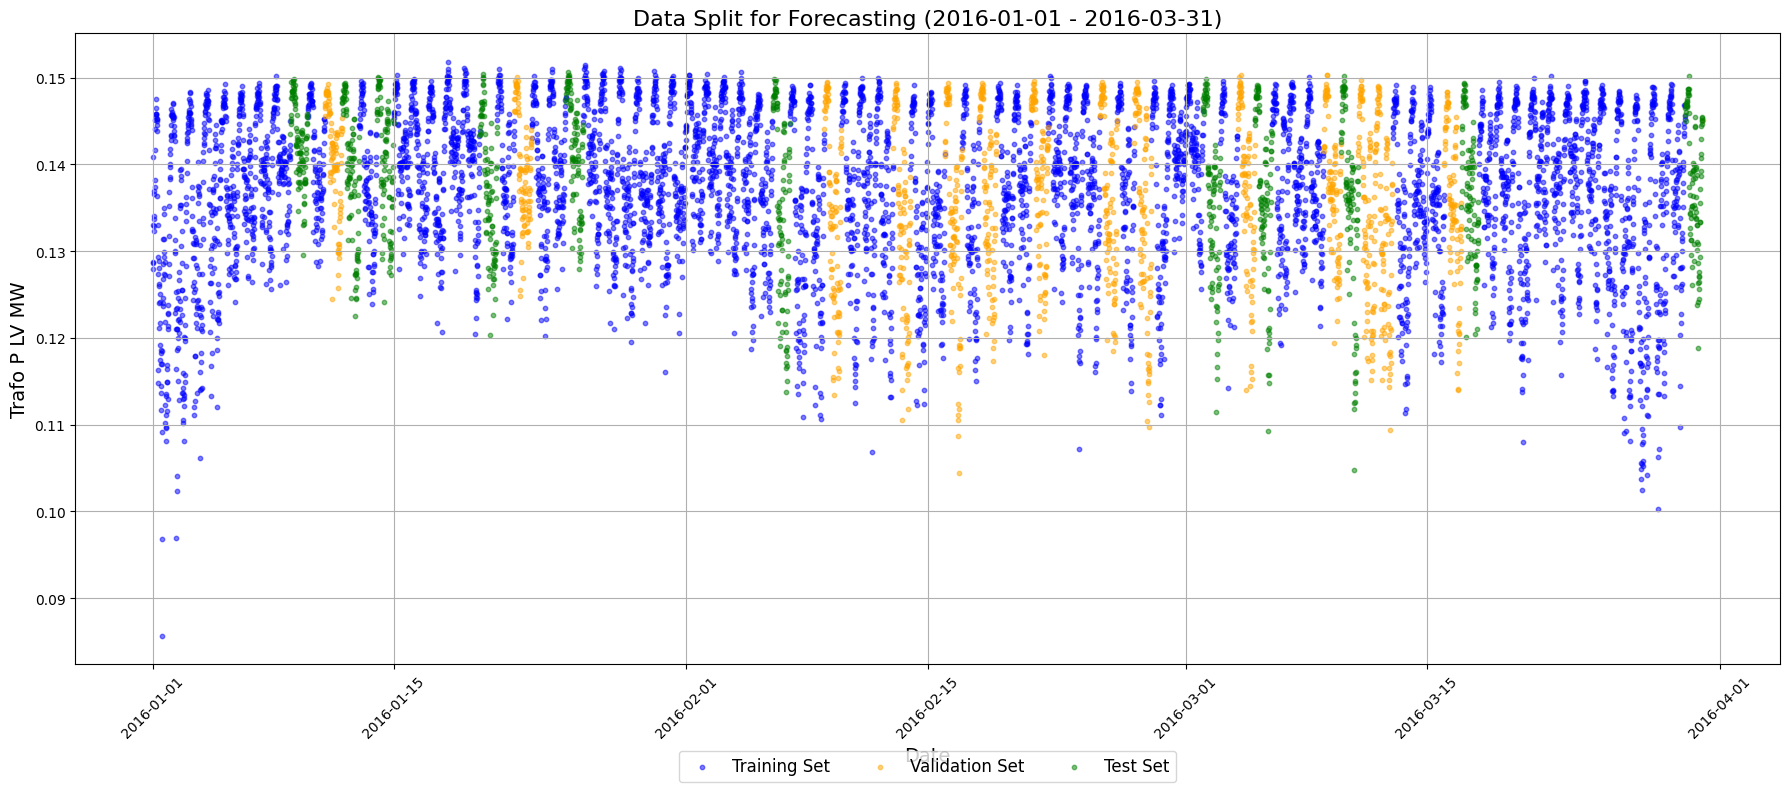

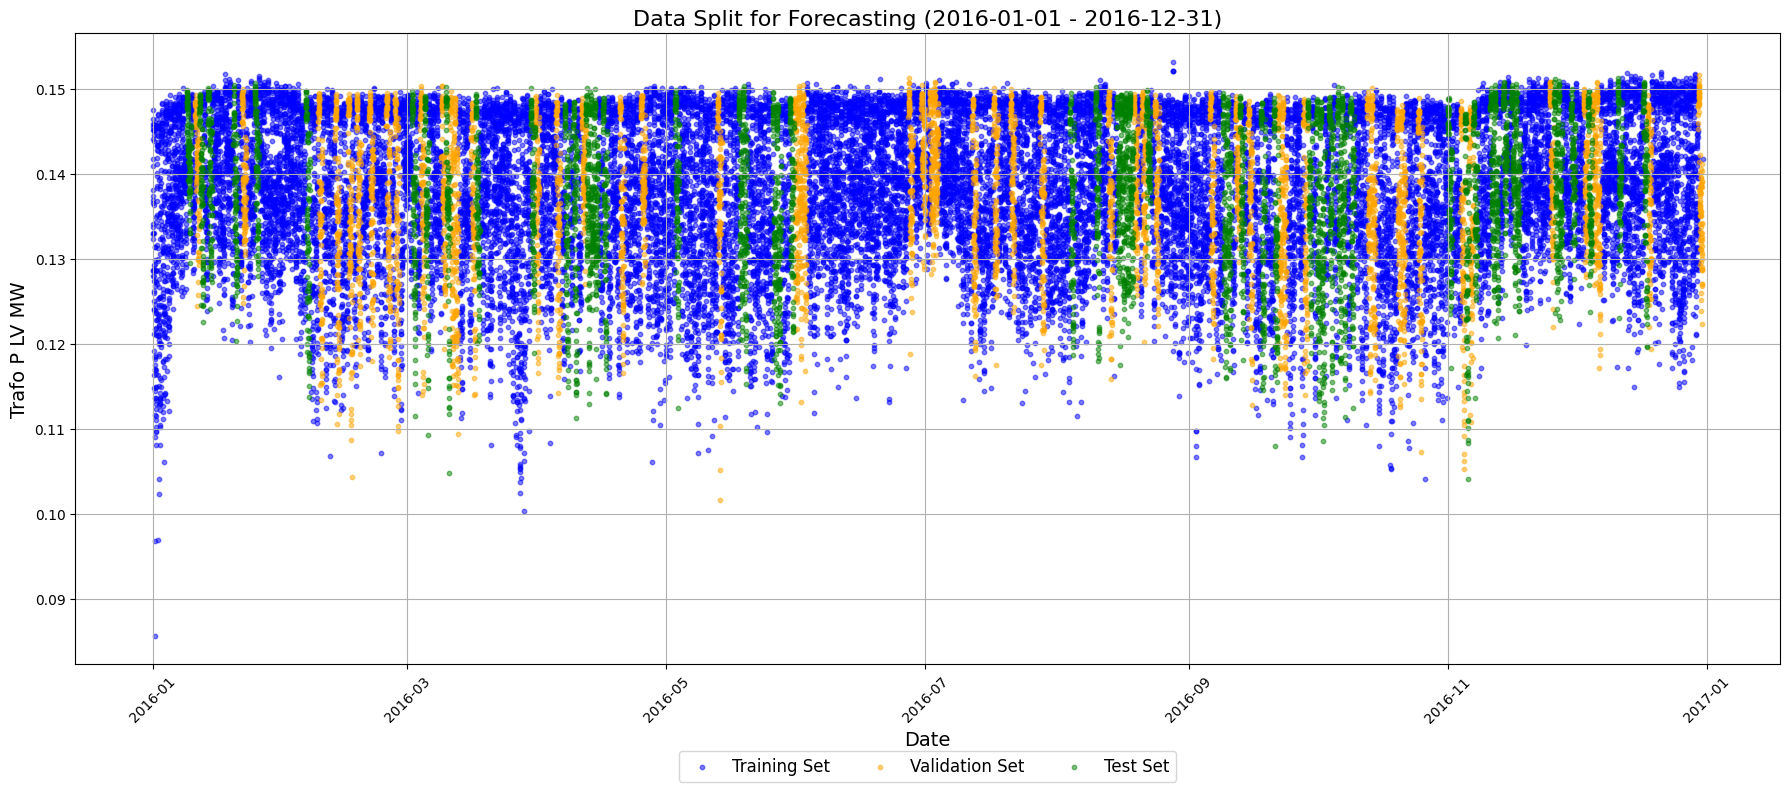

In [13]:
# Example usage
plot_date_range('2016-01-01', '2016-03-31', train_df, val_df, test_df)
plot_date_range('2016-01-01', '2016-12-31', train_df, val_df, test_df)

In [14]:
# Split the data into feature and target variables
X_train = train_df.drop(columns=[col for col in train_df.columns if 'trafo' in col])
y_train = train_df['trafo_p_lv_mw']
# Convert y_train to a DataFrame
y_train = pd.DataFrame(y_train)

X_val = val_df.drop(columns=[col for col in val_df.columns if 'trafo' in col])
y_val = val_df['trafo_p_lv_mw']
# Convert y_val to a DataFrame
y_val = pd.DataFrame(y_val)


X_test = test_df.drop(columns=[col for col in test_df.columns if 'trafo' in col])
y_test = test_df['trafo_p_lv_mw']

# Convert y_train to a DataFrame
y_test = pd.DataFrame(y_test)

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(24576, 38) (24576, 1)
(5184, 38) (5184, 1)
(5376, 38) (5376, 1)


In [15]:
# For the Moving Average Model the validation is not needed. We Split 50% to the training data and 50% to the test data
# Take the first 50% of the data from validation for training and the rest for testing
X_train = pd.concat([X_train, X_val.iloc[:len(X_val) // 2]])
y_train = pd.concat([y_train, y_val.iloc[:len(y_val) // 2]])

X_test = pd.concat([X_test, X_val.iloc[len(X_val) // 2:]])
y_test = pd.concat([y_test, y_val.iloc[len(y_val) // 2:]])

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27168, 38) (27168, 1)
(7968, 38) (7968, 1)


In [16]:
X_train.head()

,datetime,year,quarter,month,day,hour,day_of_week,is_weekend,load_p_LV1.101 Bus 10,load_p_LV1.101 Bus 8,...,load_q_LV1.101 Bus 1,load_q_LV1.101 Bus 7,load_q_LV1.101 Bus 12,load_q_LV1.101 Bus 11,load_q_LV1.101 Bus 2,load_q_LV1.101 Bus 5,sgen_p_LV1.101 Bus 7,sgen_p_LV1.101 Bus 11,sgen_p_LV1.101 Bus 8,sgen_p_LV1.101 Bus 13
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,2016,1,1,1,0,4,0,0.001926,0.000711,...,0.001806,0.000387,0.000595,-0.000053,0.000198,0.001806,0.0,0.0,0.0,0.0
2016-01-01 00:15:00,2016-01-01 00:15:00,2016,1,1,1,0,4,0,0.001905,0.000201,...,0.001916,0.000411,0.002786,0.000048,0.000929,0.001916,0.0,0.0,0.0,0.0
2016-01-01 00:30:00,2016-01-01 00:30:00,2016,1,1,1,0,4,0,0.002505,0.000191,...,0.002199,0.000471,0.002878,0.000059,0.000959,0.002199,0.0,0.0,0.0,0.0
2016-01-01 00:45:00,2016-01-01 00:45:00,2016,1,1,1,0,4,0,0.002242,0.000196,...,0.002186,0.000469,0.002927,0.000008,0.000976,0.002186,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,2016-01-01 01:00:00,2016,1,1,1,1,4,0,0.002463,0.000228,...,0.001940,0.000416,0.002983,0.000020,0.000994,0.001940,0.0,0.0,0.0,0.0


In [17]:
y_test.head()

,trafo_p_lv_mw
datetime,
2016-01-09 00:00:00,0.143476
2016-01-09 00:15:00,0.145298
2016-01-09 00:30:00,0.144701
2016-01-09 00:45:00,0.144995
2016-01-09 01:00:00,0.145753


In [18]:
from pylab import rcParams
import statsmodels.api as sm

In [19]:
y_train

,trafo_p_lv_mw
datetime,
2016-01-01 00:00:00,0.140890
2016-01-01 00:15:00,0.133022
2016-01-01 00:30:00,0.128641
2016-01-01 00:45:00,0.128708
2016-01-01 01:00:00,0.127994
...,...
2016-07-03 22:45:00,0.147302
2016-07-03 23:00:00,0.146913
2016-07-03 23:15:00,0.148322


In [20]:
# Step 1: Calculate Moving Average
# Define the window size for the moving average
window_size = 8  # Adjust the window size as needed

# Calculate the moving average for y_train
y_train_ma = y_train.rolling(window=window_size).mean()

# Drop NaN values resulting from the rolling mean calculation
y_train_ma = y_train_ma.dropna()

In [21]:
# Step 2: Make Predictions (Use moving average as predictions)
y_test_pred = y_train_ma[-len(y_test):]

In [22]:
# Evaluate the model
evaluation_results = evaluate_regression(y_test, y_test_pred, X_test)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

MAE: 0.005558269410392053
MSE: 5.642876522127637e-05
MEDAE: 0.004071212149632353
RMSE: 0.007511908227692639
R^2: 0.2550428675664631
Adjusted R^2: 0.2514726353767198
MAPE: nan


c:\Programming\hslu_masterthesis\Masterthesis\notebooks\masterthesis_helper_functions.py:124: RuntimeWarning: Mean of empty slice
  mape = np.nanmean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100


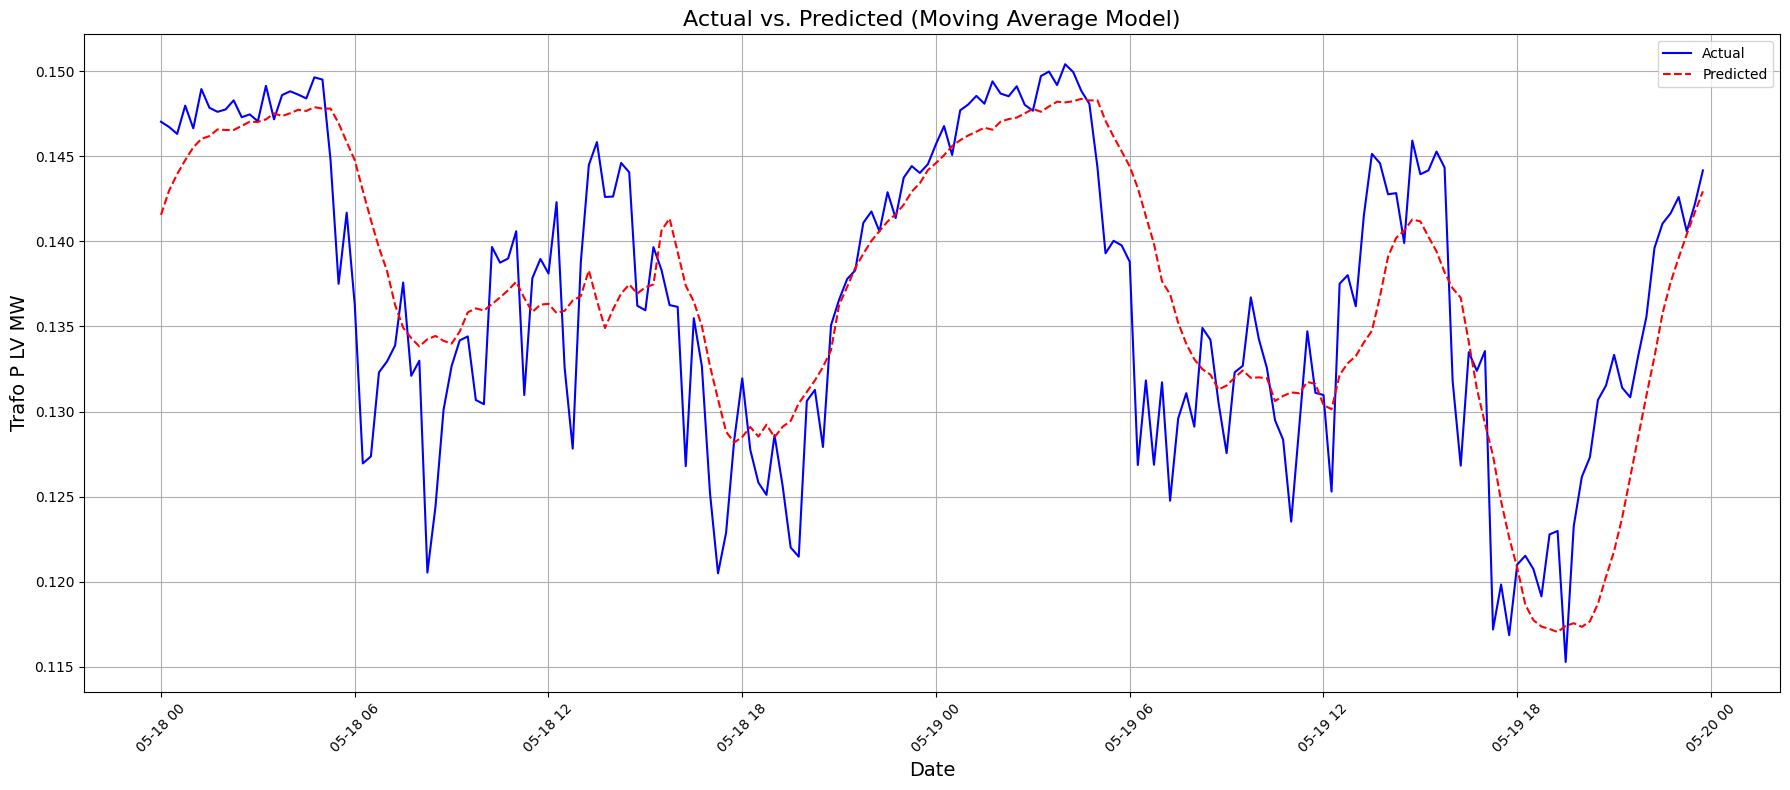

In [29]:
# Plot the actual vs. predicted values for a given date range
plot_actual_vs_predicted_time_series('2016-05-17', '2016-05-20', y_test, y_test_pred, title='Actual vs. Predicted (Moving Average Model)', xlabel='Date', ylabel='Trafo P LV MW')

# Model for 1 h

In [35]:
# Usage
forecast_window = '1h' # Adjust the forecast_window according to your needs
train_df, val_df, test_df = split_data_forecasting_window_with_validation(Combined_Load_And_TrafoData, forecast_window, train_size=0.70, val_size=0.15, seed=4711)

# Verify the splits
print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {val_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

All Windows: [3389, 934, 1520, 3980, 854, 7910, 4371, 1074, 7817, 3717, 3210, 6423, 6550, 784, 1149, 2615, 1018, 1744, 7770, 2802, 6515, 6179, 405, 4655, 7506, 5709, 1117, 3823, 2249, 5809, 3420, 50, 1982, 6055, 8532, 6353, 5927, 3004, 6698, 2080, 5984, 46, 7753, 6420, 3782, 7440, 380, 3692, 5705, 4459, 28, 875, 7691, 8125, 6972, 6244, 1971, 1359, 7323, 7060, 941, 850, 846, 3298, 4131, 386, 2291, 2300, 2202, 5163, 2123, 2287, 8331, 851, 6237, 2583, 5754, 3682, 2829, 1684, 4239, 3976, 3524, 6682, 4276, 624, 8482, 2477, 697, 7951, 8749, 7272, 1515, 3590, 1441, 3463, 8436, 3799, 3436, 762, 5216, 4427, 48, 326, 6813, 5122, 2769, 6279, 343, 5743, 2871, 3832, 1240, 1229, 5445, 1539, 8195, 2340, 3139, 2554, 6137, 2193, 6411, 7269, 7038, 2824, 8217, 292, 2848, 2179, 8146, 5265, 8607, 1968, 6088, 2547, 366, 2225, 4841, 3088, 6114, 6393, 4623, 2006, 7198, 8117, 8372, 6957, 1981, 8530, 1448, 920, 5784, 4216, 6530, 7745, 5953, 7823, 5549, 4890, 3626, 4445, 1724, 1105, 312, 7427, 5214, 1797, 795, 4

In [36]:
# Split the data into feature and target variables
X_train = train_df.drop(columns=[col for col in train_df.columns if 'trafo' in col])
y_train = train_df['trafo_p_lv_mw']
# Convert y_train to a DataFrame
y_train = pd.DataFrame(y_train)

X_val = val_df.drop(columns=[col for col in val_df.columns if 'trafo' in col])
y_val = val_df['trafo_p_lv_mw']
# Convert y_val to a DataFrame
y_val = pd.DataFrame(y_val)


X_test = test_df.drop(columns=[col for col in test_df.columns if 'trafo' in col])
y_test = test_df['trafo_p_lv_mw']

# Convert y_train to a DataFrame
y_test = pd.DataFrame(y_test)

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# For the Moving Average Model the validation is not needed. We Split 50% to the training data and 50% to the test data
# Take the first 50% of the data from validation for training and the rest for testing
X_train = pd.concat([X_train, X_val.iloc[:len(X_val) // 2]])
y_train = pd.concat([y_train, y_val.iloc[:len(y_val) // 2]])

X_test = pd.concat([X_test, X_val.iloc[len(X_val) // 2:]])
y_test = pd.concat([y_test, y_val.iloc[len(y_val) // 2:]])

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(24592, 38) (24592, 1)
(5268, 38) (5268, 1)
(5276, 38) (5276, 1)
(27226, 38) (27226, 1)
(7910, 38) (7910, 1)


MAE: 0.007984986427973857
MSE: 9.971246036046676e-05
MEDAE: 0.006694357532710013
RMSE: 0.009985612668257605
R^2: -0.373310097178813
Adjusted R^2: -0.37994023104907027
MAPE: nan


c:\Programming\hslu_masterthesis\Masterthesis\notebooks\masterthesis_helper_functions.py:124: RuntimeWarning: Mean of empty slice
  mape = np.nanmean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100


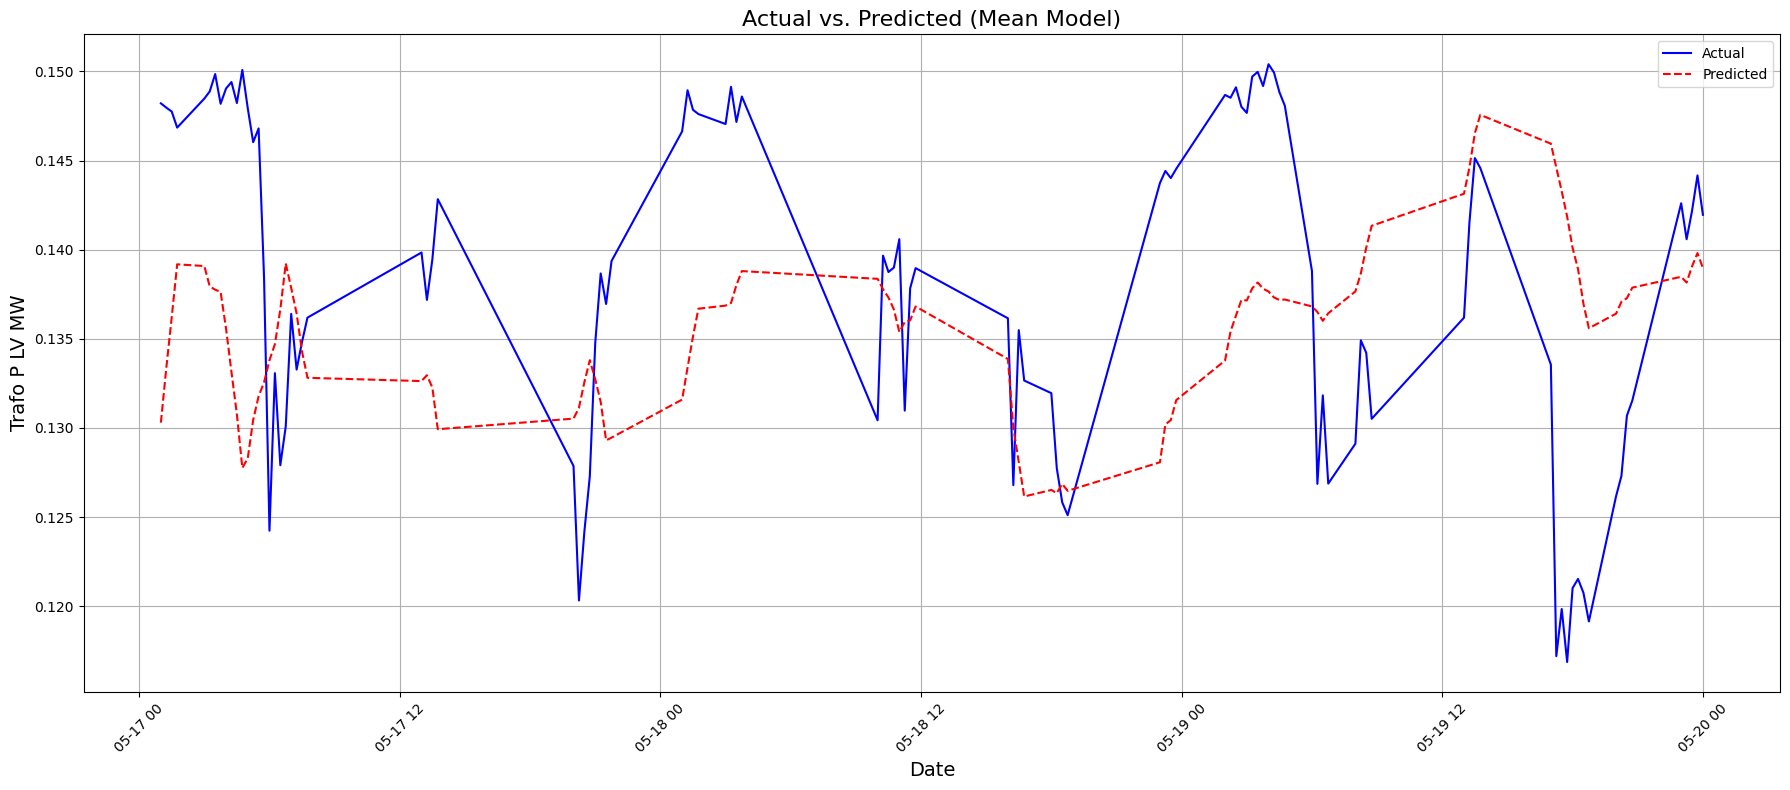

In [37]:
# Step 1: Calculate Moving Average
# Define the window size for the moving average
window_size = 8  # Adjust the window size as needed

# Calculate the moving average for y_train
y_train_ma = y_train.rolling(window=window_size).mean()

# Drop NaN values resulting from the rolling mean calculation
y_train_ma = y_train_ma.dropna()

# Step 2: Make Predictions (Use moving average as predictions)
y_test_pred = y_train_ma[-len(y_test):]

# Evaluate the model
evaluation_results = evaluate_regression(y_test, y_test_pred, X_test)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Plot the actual vs. predicted values for a given date range
plot_actual_vs_predicted_time_series('2016-05-17', '2016-05-20', y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Date', ylabel='Trafo P LV MW')

# Model for 4h

In [38]:
# Usage
forecast_window = '6h' # Adjust the forecast_window according to your needs
train_df, val_df, test_df = split_data_forecasting_window_with_validation(Combined_Load_And_TrafoData, forecast_window, train_size=0.70, val_size=0.15, seed=4711)

# Verify the splits
print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {val_df.shape}")
print(f"Testing Data Shape: {test_df.shape}")

All Windows: [768, 664, 1244, 240, 488, 1129, 1109, 852, 1093, 898, 948, 1433, 984, 866, 570, 13, 323, 208, 561, 412, 839, 1440, 998, 1153, 772, 79, 649, 1317, 414, 1345, 855, 439, 1127, 1389, 407, 695, 1312, 722, 238, 1147, 144, 716, 527, 255, 960, 841, 44, 1082, 116, 456, 681, 262, 1432, 337, 785, 764, 946, 707, 1117, 1387, 1167, 429, 1247, 484, 523, 1401, 1364, 1327, 320, 176, 672, 1296, 225, 1264, 340, 464, 899, 249, 248, 199, 1212, 862, 1439, 1028, 317, 958, 11, 1242, 613, 593, 951, 1458, 1013, 914, 253, 1278, 653, 185, 894, 300, 475, 479, 910, 563, 180, 286, 1321, 810, 507, 1353, 897, 1049, 1032, 983, 219, 1187, 625, 46, 1183, 419, 381, 1375, 1236, 1362, 647, 173, 66, 405, 1097, 105, 506, 424, 717, 235, 477, 1100, 1444, 101, 84, 319, 880, 211, 669, 687, 968, 757, 729, 154, 107, 1214, 752, 856, 1415, 578, 800, 1265, 1173, 598, 805, 50, 400, 47, 632, 58, 628, 232, 1228, 465, 141, 1339, 1360, 1324, 730, 825, 1192, 1015, 686, 1315, 1450, 209, 754, 549, 295, 744, 1304, 1086, 1143, 98,

In [39]:
# Split the data into feature and target variables
X_train = train_df.drop(columns=[col for col in train_df.columns if 'trafo' in col])
y_train = train_df['trafo_p_lv_mw']
# Convert y_train to a DataFrame
y_train = pd.DataFrame(y_train)

X_val = val_df.drop(columns=[col for col in val_df.columns if 'trafo' in col])
y_val = val_df['trafo_p_lv_mw']
# Convert y_val to a DataFrame
y_val = pd.DataFrame(y_val)


X_test = test_df.drop(columns=[col for col in test_df.columns if 'trafo' in col])
y_test = test_df['trafo_p_lv_mw']

# Convert y_train to a DataFrame
y_test = pd.DataFrame(y_test)

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# For the Moving Average Model the validation is not needed. We Split 50% to the training data and 50% to the test data
# Take the first 50% of the data from validation for training and the rest for testing
X_train = pd.concat([X_train, X_val.iloc[:len(X_val) // 2]])
y_train = pd.concat([y_train, y_val.iloc[:len(y_val) // 2]])

X_test = pd.concat([X_test, X_val.iloc[len(X_val) // 2:]])
y_test = pd.concat([y_test, y_val.iloc[len(y_val) // 2:]])

# Verify the shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(24576, 38) (24576, 1)
(5256, 38) (5256, 1)
(5304, 38) (5304, 1)
(27204, 38) (27204, 1)
(7932, 38) (7932, 1)


c:\Programming\hslu_masterthesis\Masterthesis\notebooks\masterthesis_helper_functions.py:124: RuntimeWarning: Mean of empty slice
  mape = np.nanmean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100


MAE: 0.008788158659601078
MSE: 0.00011970974615043079
MEDAE: 0.007535211838957792
RMSE: 0.010941194914196109
R^2: -0.8016780146160478
Adjusted R^2: -0.8103519997364597
MAPE: nan


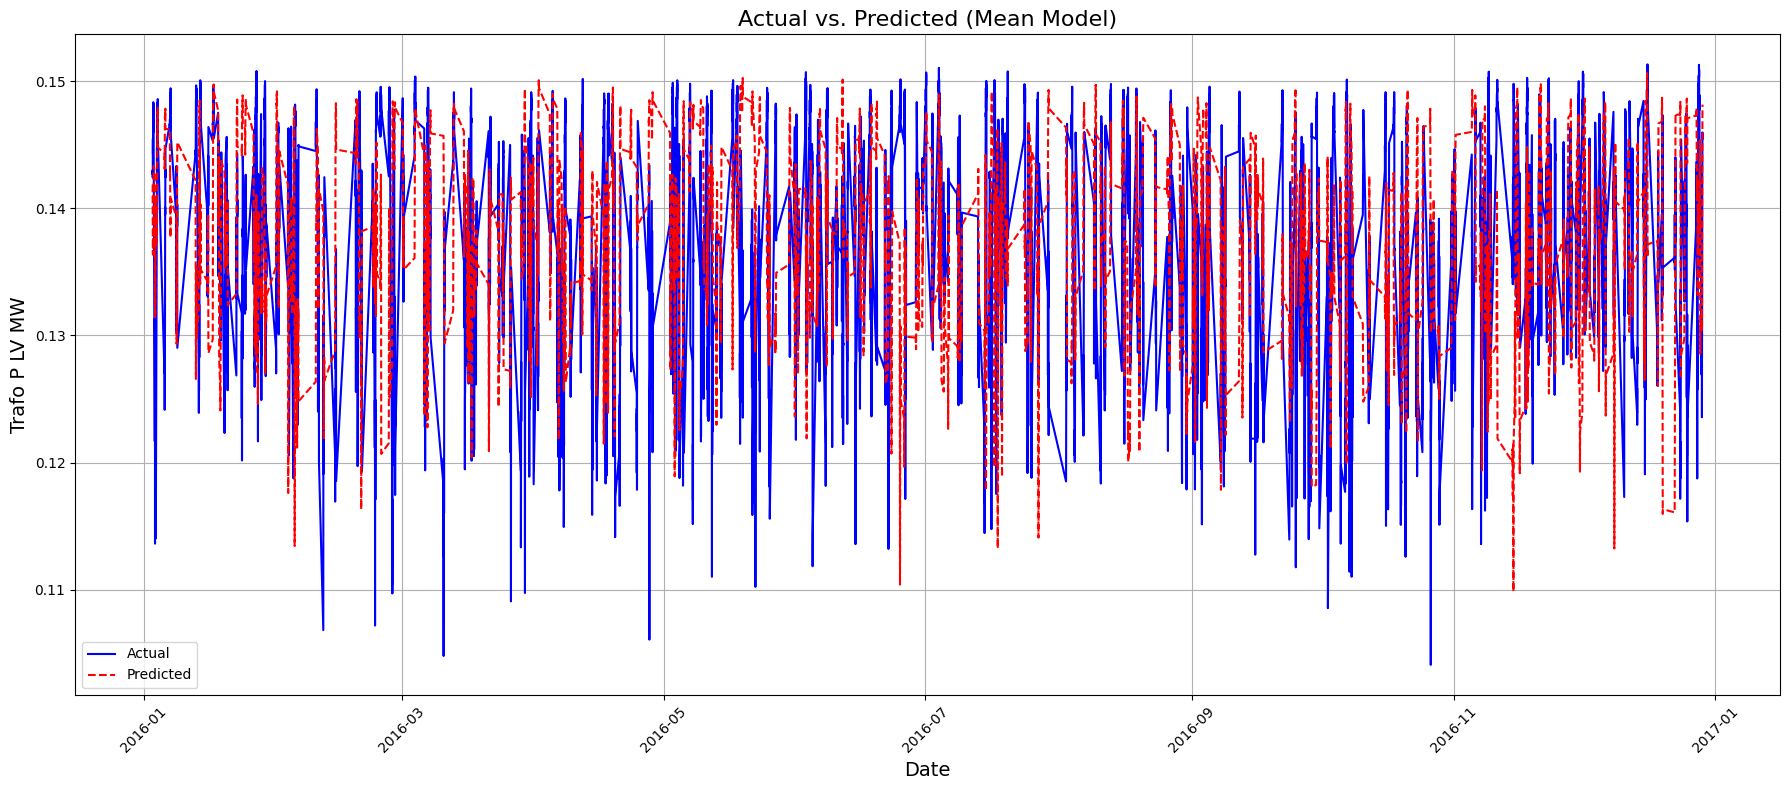

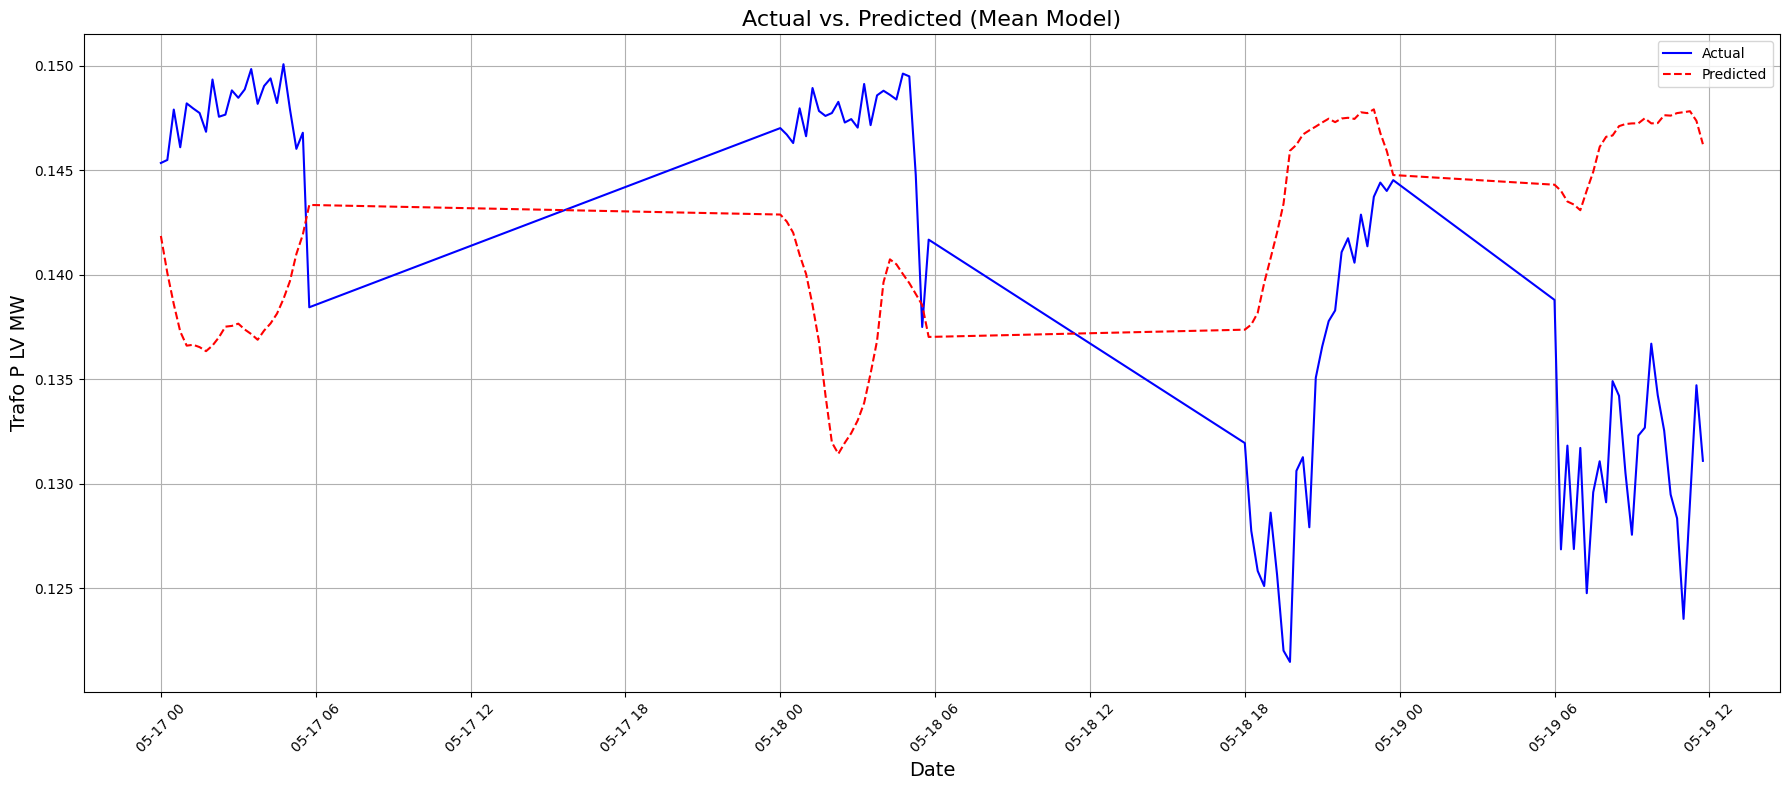

In [40]:
# Step 1: Calculate Moving Average
# Define the window size for the moving average
window_size = 8  # Adjust the window size as needed

# Calculate the moving average for y_train
y_train_ma = y_train.rolling(window=window_size).mean()

# Drop NaN values resulting from the rolling mean calculation
y_train_ma = y_train_ma.dropna()

# Step 2: Make Predictions (Use moving average as predictions)
y_test_pred = y_train_ma[-len(y_test):]

# Evaluate the model
evaluation_results = evaluate_regression(y_test, y_test_pred, X_test)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Plot the actual vs. predicted values for a given date range
plot_actual_vs_predicted_time_series('2016-01-01', '2016-12-31', y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Date', ylabel='Trafo P LV MW')
plot_actual_vs_predicted_time_series('2016-05-17', '2016-05-20', y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Date', ylabel='Trafo P LV MW')

# 15min

In [30]:
from sklearn.model_selection import train_test_split

# Assuming Combined_Load_And_TrafoData is your DataFrame with features and target variable
# Replace 'target_column_name' with the actual name of your target column
X = Combined_Load_And_TrafoData.drop(columns=['trafo_p_lv_mw'])
y = Combined_Load_And_TrafoData['trafo_p_lv_mw']

# Split the data into training and testing sets
# Adjust the test_size parameter as needed, for example, test_size=0.2 for a 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)

c:\Programming\hslu_masterthesis\Masterthesis\notebooks\masterthesis_helper_functions.py:124: RuntimeWarning: Mean of empty slice
  mape = np.nanmean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100


MAE: 0.00744481623007816
MSE: 8.388601924013564e-05
MEDAE: 0.00670933980915267
RMSE: 0.009158931118866198
R^2: -0.1322926782038527
Adjusted R^2: -0.14040714486720263
MAPE: nan


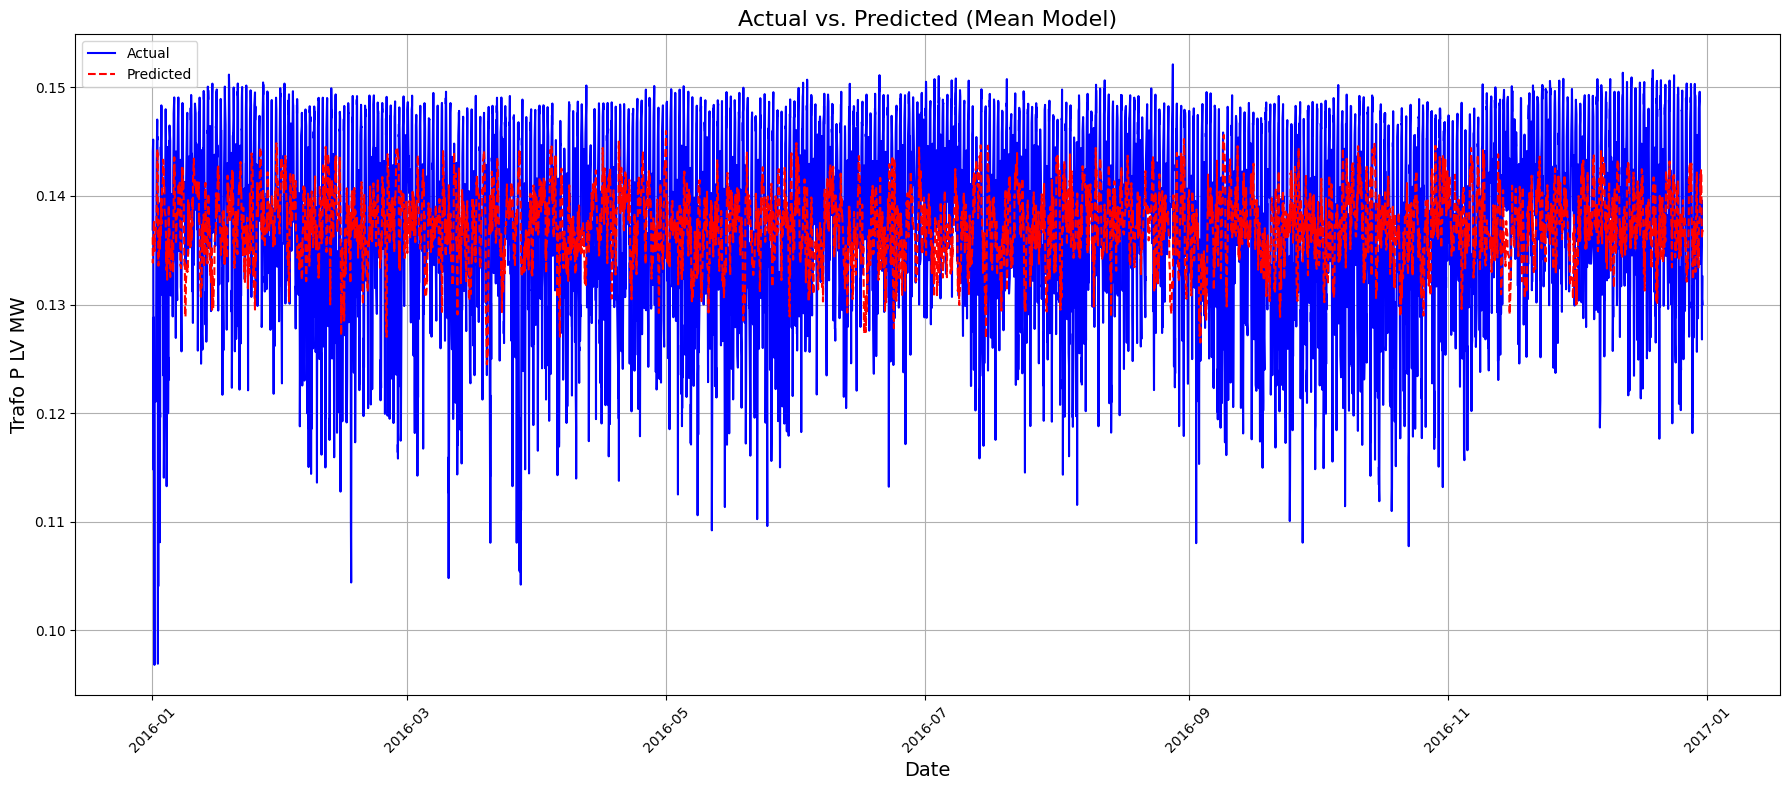

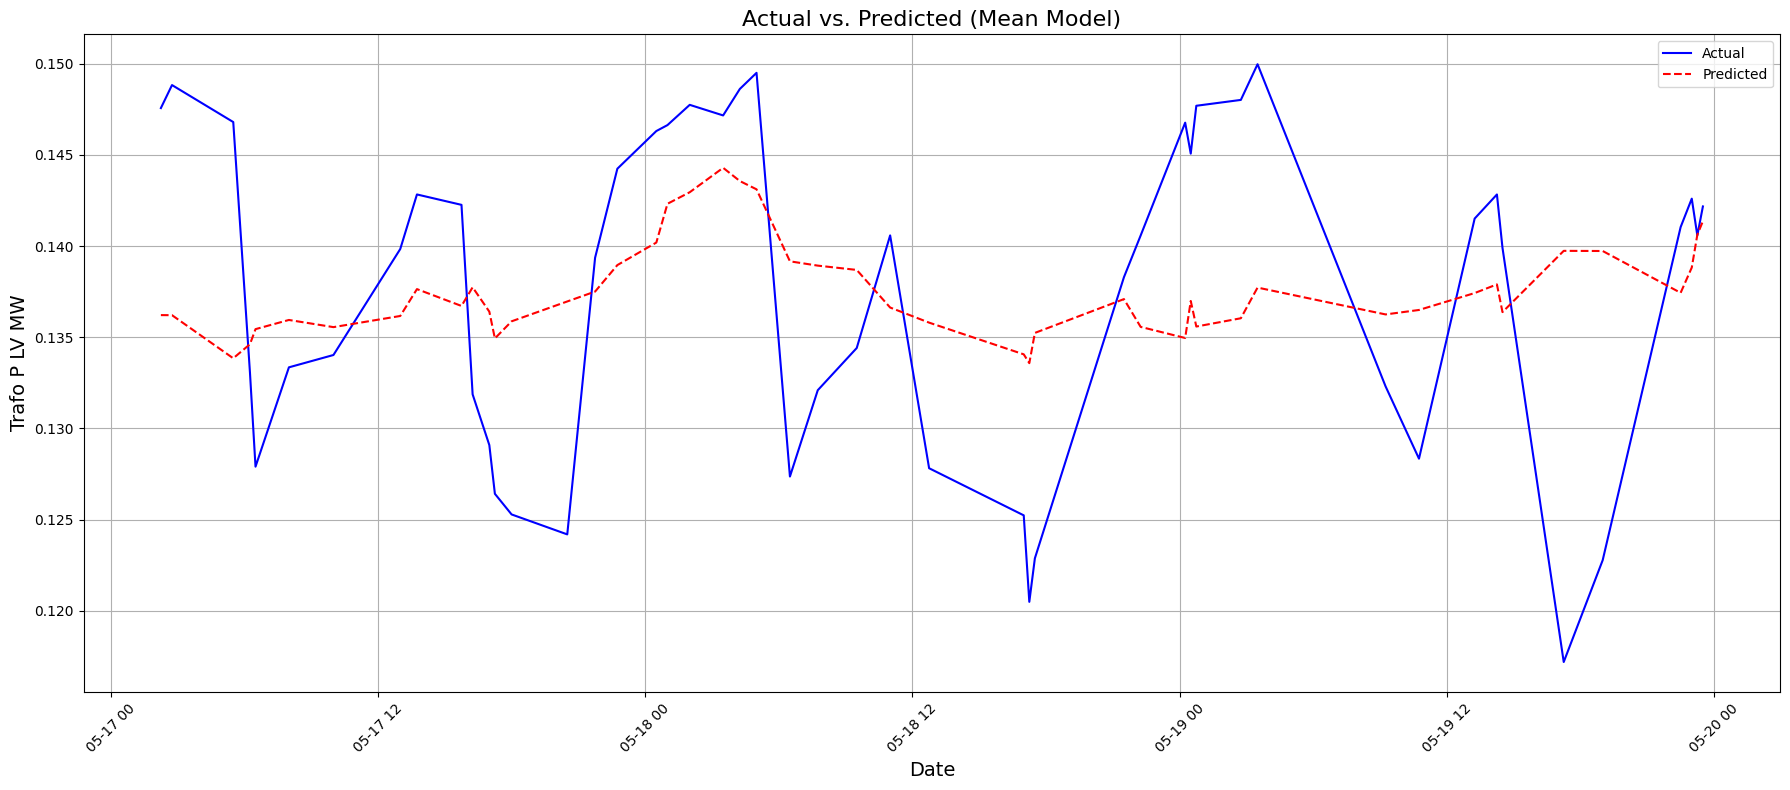

In [31]:
# Step 1: Calculate Moving Average
# Define the window size for the moving average
window_size = 8  # Adjust the window size as needed

# Calculate the moving average for y_train
y_train_ma = y_train.rolling(window=window_size).mean()

# Drop NaN values resulting from the rolling mean calculation
y_train_ma = y_train_ma.dropna()

# Step 2: Make Predictions (Use moving average as predictions)
y_test_pred = y_train_ma[-len(y_test):]

# Evaluate the model
evaluation_results = evaluate_regression(y_test, y_test_pred, X_test)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f"{metric}: {value}")

# Plot the actual vs. predicted values for a given date range
plot_actual_vs_predicted_time_series('2016-01-01', '2016-12-31', y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Date', ylabel='Trafo P LV MW')
plot_actual_vs_predicted_time_series('2016-05-17', '2016-05-20', y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Date', ylabel='Trafo P LV MW')

In [ ]:
# Plot the actual vs. predicted 
plot_actual_vs_predicted(y_test, y_test_pred, title='Actual vs. Predicted (Mean Model)', xlabel='Actual', ylabel='Predicted')